In [128]:
# import required libraries
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt
#/Users/djbautista/Desktop/437/radar/data_12_01_2023_17_52_47.npy
rawData = np.load("/Users/djbautista/Desktop/437/radar/data_12_01_2023_17_52_47.npy")
data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])
data.shape # chirp* rx * samples per chirp

(800, 3, 128)

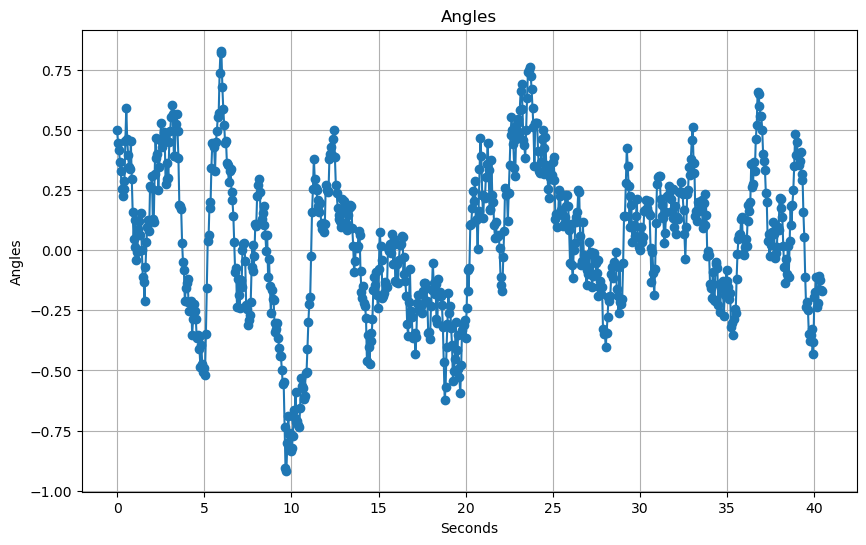

In [129]:
#when calling this function, enter the data and the bin number(distance from radar divided by 
# approximately 4 cm)
def getPhaseData(data, binNum):
    rangeData = np.fft.fftn(data, axes=(2,))
    closest=rangeData[:,:,binNum]
    rangeDoppler = np.fft.fftn(closest, axes=(0,))
    doppler=rangeDoppler[:,0]
    angles = np.angle(doppler)
    window_size=30

    cumsum= np.cumsum(np.insert(angles,0,0))
    smoothed_data=(cumsum[window_size:]-cumsum[:-window_size])/float(window_size)

    plt.figure(figsize=(10, 6))
    plt.plot([0.0525 * x for x in range(len(smoothed_data))], smoothed_data, marker='o', linestyle='-')
    plt.title("Angles")
    plt.xlabel("Seconds")
    plt.ylabel("Angles")
    plt.grid()
    plt.show()
    return smoothed_data
#return phase data and graph out results
phase = getPhaseData(data, 1)

Breathing Rate: 8.93 breaths per minute


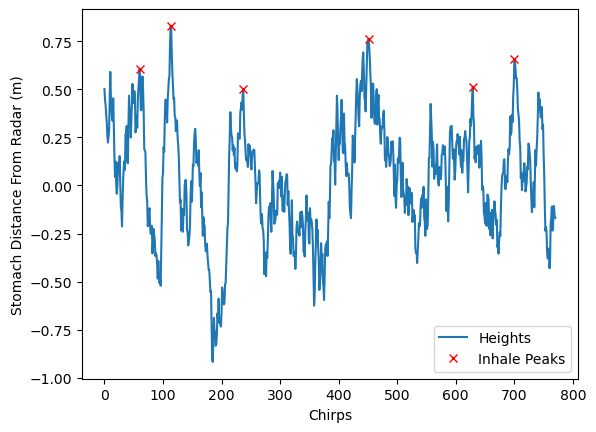

In [130]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

#get peaks of Inhale
def label_breathing_pattern(heights, prominence_threshold):
    peaks, _ = find_peaks(heights, distance=10, prominence=prominence_threshold)
    minima, _ = find_peaks(-heights, distance=10, prominence=prominence_threshold)
    events = np.sort(np.concatenate([peaks, minima]))
    labels = np.zeros_like(heights, dtype=int)
    labels[events] = np.where(np.isin(events, peaks), 1, -1)
    return labels, peaks, minima

#return breathing rate
def calculate_breathing_rate(inhale_peaks, time_per_sample):
    inhale_times = inhale_peaks * time_per_sample
    inhale_time_diff = np.diff(inhale_times)

    breathing_rate = 60 / np.mean(inhale_time_diff)
    return breathing_rate

#Change these depending on time period and peak prominence 
prominence_threshold = 0.8  
time_per_sample = 0.0525

breathing_labels, inhale_peaks, _ = label_breathing_pattern(phase, prominence_threshold)
rate = calculate_breathing_rate(inhale_peaks, time_per_sample)

print(f"Breathing Rate: {rate:.2f} breaths per minute")
plt.plot(phase, label='Heights')
plt.plot(inhale_peaks, phase[inhale_peaks], 'rx', label='Inhale Peaks')

plt.xlabel('Chirps')
plt.ylabel('Stomach Distance From Radar (m)')
plt.legend()
plt.show()
#plot data with breathing rate

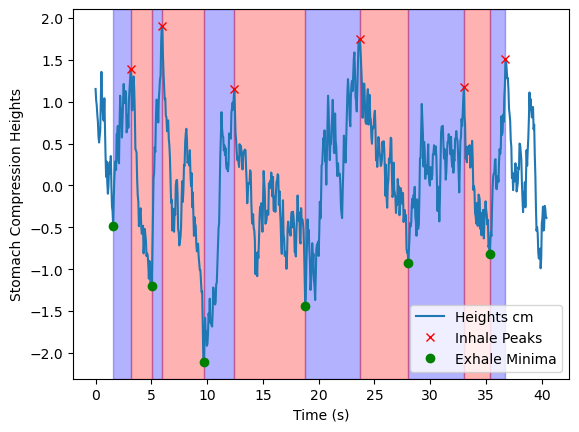

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

prominence_threshold = 0.8  

breathing_labels, inhale_peaks, exhale_minima = label_breathing_pattern(phase, prominence_threshold)
inhale_peaks_c=inhale_peaks
exhale_minima_c=exhale_minima
phase*=2.3
plt.plot([0.0525 * x for x in range(len(phase))], phase, label='Heights cm')
plt.plot(inhale_peaks*0.0525 , phase[inhale_peaks], 'rx', label='Inhale Peaks')
plt.plot(exhale_minima*0.0525, phase[exhale_minima], 'go', label='Exhale Minima')
inhale_peaks = inhale_peaks.astype('float64')
inhale_peaks*=0.0525
exhale_minima  = exhale_minima.astype('float64')
exhale_minima*=0.0525
for i in range(0, len(inhale_peaks), 2):
    plt.axvspan(exhale_minima[i], inhale_peaks[i], color='blue', alpha=0.3, )

for i in range(1, len(exhale_minima), 2):
    plt.axvspan(inhale_peaks[i], exhale_minima[i], color='blue', alpha=0.3, )

for i in range(0, len(inhale_peaks) - 1):
    plt.axvspan(inhale_peaks[i], exhale_minima[i + 1], color='red', alpha=0.3, )
#Use regions to define inhale and exhae by using the peak array

plt.xlabel('Time (s)')
plt.ylabel('Stomach Compression Heights')
plt.legend()
plt.show()


Red is exhale, Blue is inhale

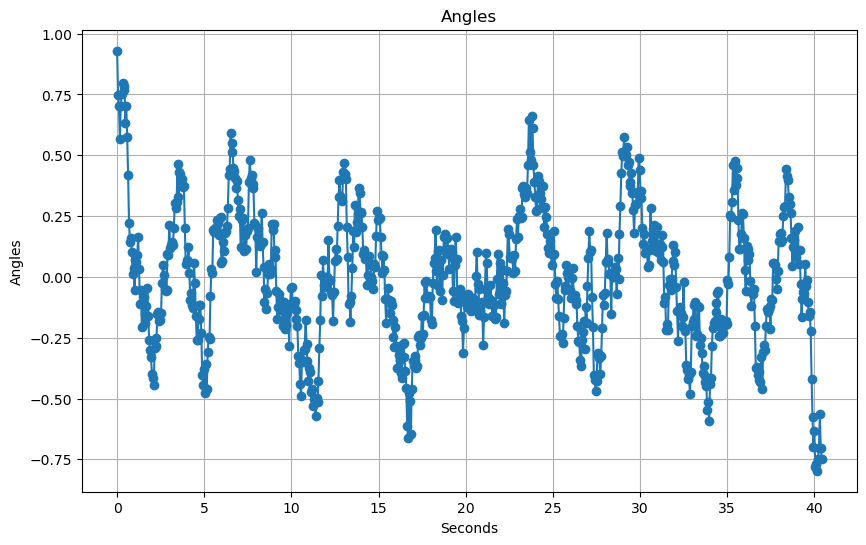

Breathing Rate: 10.31 breaths per minute


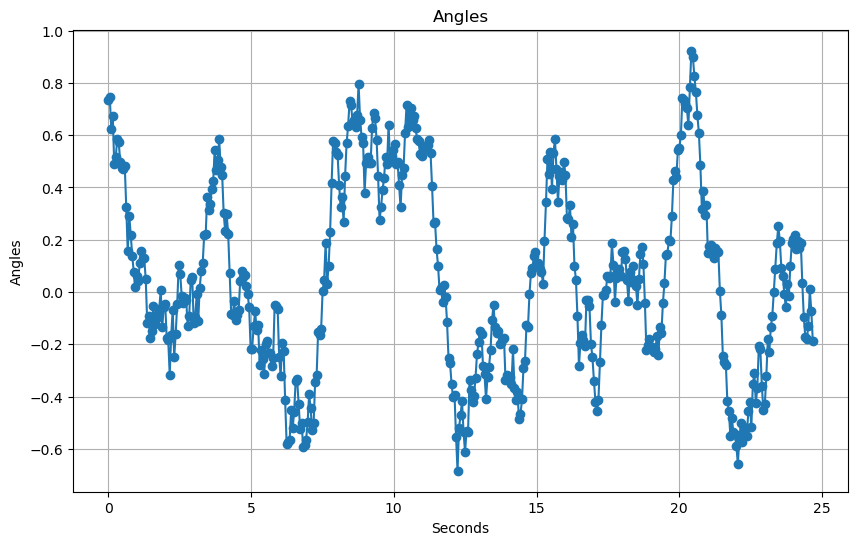

Breathing Rate: 10.88 breaths per minute


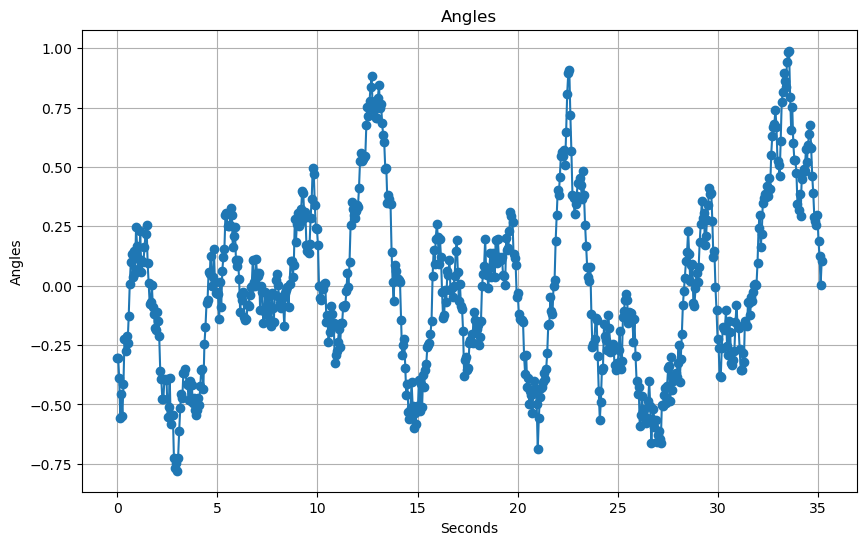

Breathing Rate: 9.35 breaths per minute


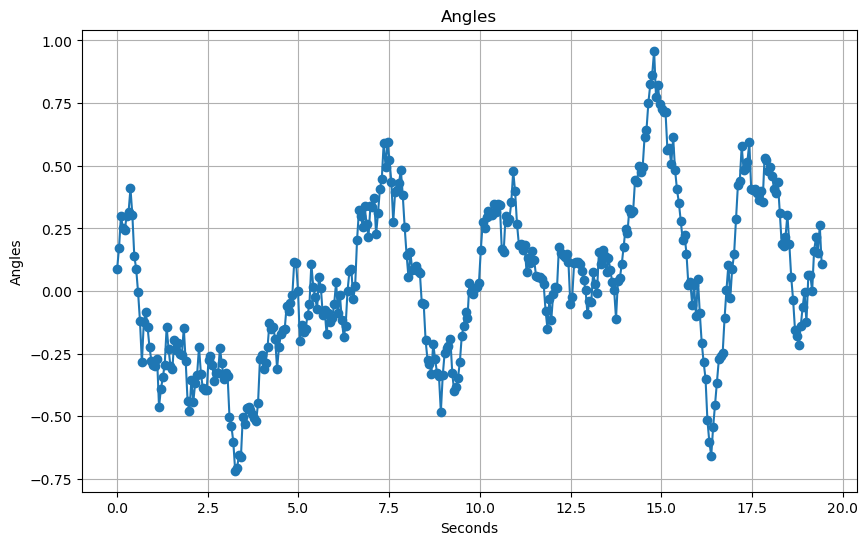

Breathing Rate: 12.03 breaths per minute


Text(0.5, 1.0, 'Distance vs Accuracy')

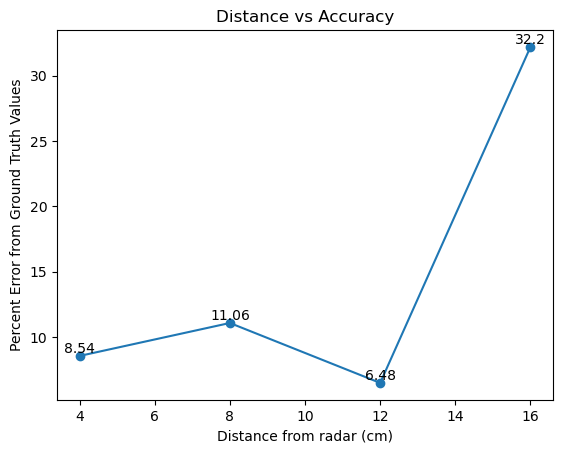

In [132]:
#These paths are data recorded at varying distances: (4, 8, 12, 16 cm away)
paths =["/Users/djbautista/Desktop/437/radar/data_12_01_2023_17_52_47.npy",
        "/Users/djbautista/Desktop/437/radar/data_12_03_2023_16_39_36.npy",
        "/Users/djbautista/Desktop/437/radar/data_12_01_2023_18_01_20.npy",
        "/Users/djbautista/Desktop/437/radar/data_12_01_2023_16_50_02.npy",
]
#These rates are ground truth values recorded in person
rates=[9.5,9.8,10.0,9.1,11.1]

ratesPred=[]
for i in range(4):
    rawData = np.load(paths[i])
    data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])
    phase = getPhaseData(data,i)

    breathing_labels, inhale_peaks, _ = label_breathing_pattern(phase, prominence_threshold)
    rate = calculate_breathing_rate(inhale_peaks, time_per_sample)
    ratesPred.append((abs(rate-rates[i]))*100/rates[i])
    print(f"Breathing Rate: {rate:.2f} breaths per minute")
#calculate percent difference of predicted vs actual and plot out relationship


plt.plot([4 * x+4 for x in range(len(ratesPred))], ratesPred, marker='o', linestyle='-')
for i, txt in enumerate(ratesPred):
    plt.text(4 * i+4, txt, f'{round(txt,2)}', ha='center', va='bottom')
plt.xlabel('Distance from radar (cm)')
plt.ylabel('Percent Error from Ground Truth Values')
plt.title('Distance vs Accuracy')



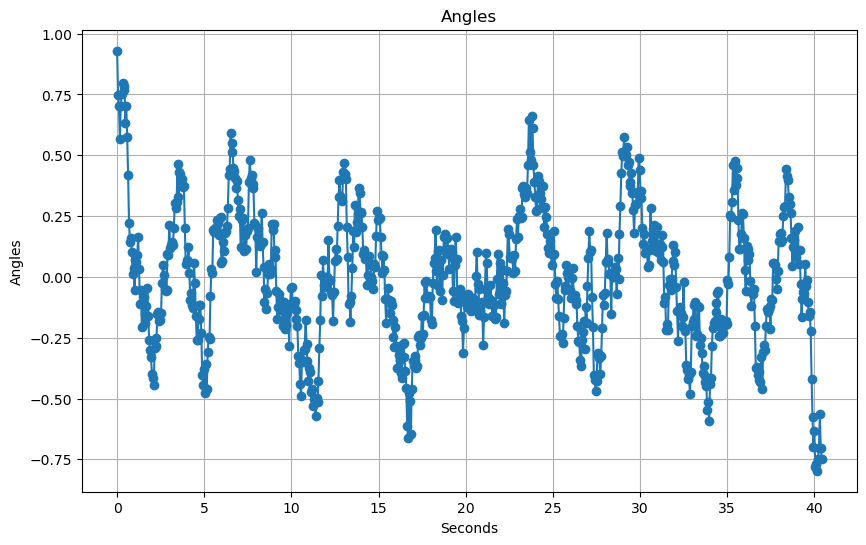

Breathing Rate: 10.31 breaths per minute


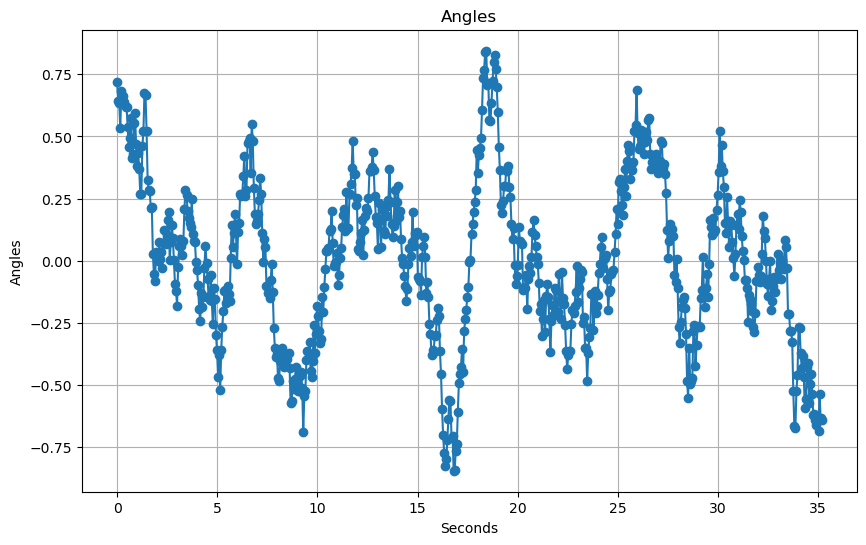

Breathing Rate: 10.27 breaths per minute


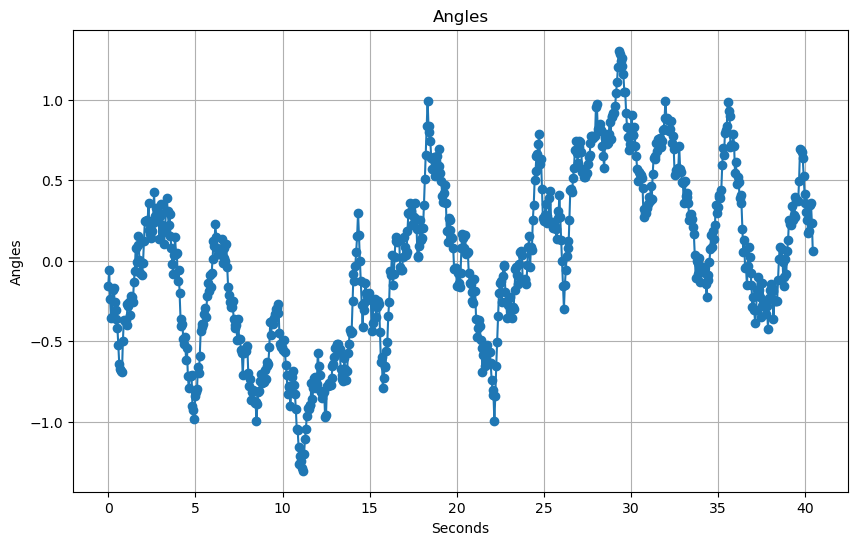

Breathing Rate: 10.94 breaths per minute


Text(0.5, 1.0, 'Accuracy Across three different People')

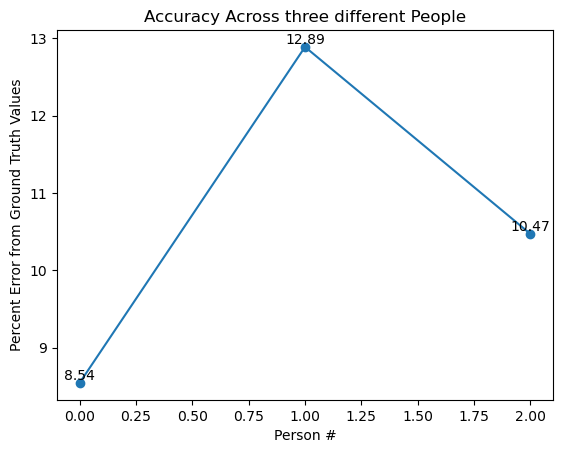

In [133]:
#This data corresponds with 3 different people woth different dimensions/body-types
pathsPeople=[
    "/Users/djbautista/Desktop/437/radar/data_12_01_2023_17_52_47.npy",
    "/Users/djbautista/Desktop/437/radar/data_12_03_2023_16_35_55.npy",
    "/Users/djbautista/Desktop/437/radar/data_12_12_2023_19_31_07.npy",
]
#These rates are ground truth values recorded in person
rates_2 = [9.5, 9.1, 9.9]
ratesPred_2=[]
for i in range(3):
    rawData = np.load(pathsPeople[i])
    data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])
    phase = getPhaseData(data,0)

    breathing_labels, inhale_peaks, _ = label_breathing_pattern(phase, prominence_threshold)
    rate = calculate_breathing_rate(inhale_peaks, time_per_sample)
    ratesPred_2.append((abs(rate-rates_2[i]))*100/rates_2[i])
    print(f"Breathing Rate: {rate:.2f} breaths per minute")
#calculate percent difference of predicted vs actual and plot out relationship

  
plt.plot( ratesPred_2, marker='o', linestyle='-')
for i, txt in enumerate(ratesPred_2):
    plt.text( i, txt, f'{round(txt,2)}', ha='center', va='bottom')
plt.xlabel('Person #')
plt.ylabel('Percent Error from Ground Truth Values')
plt.title('Accuracy Across three different People')

